In [3]:
from kafka import KafkaConsumer
from json import loads
import json
from time import sleep
import pandas as pd
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

In [4]:
token = "En1iX5zqnyR_AT71S6Ahz8_Hs78nrJHwEkZDDksf4J6reHJNqXzbaMEXbmBjy7I-bdzp2k8fy7E1FjU1f2ZWsA=="
org = "mema_org"
bucket = "mema_bucket"
url = "http://localhost:8086"

In [6]:

# KSWIN Implementation
class KSWIN:
    def __init__(self, window_size=30, alpha=0.01, kernel='linear'):
        self.window_size = window_size
        self.alpha = alpha
        self.kernel = kernel
        self.data_buffer = []
        self.change_detected = False

    def add_element(self, value):
        self.data_buffer.append(value)

        if len(self.data_buffer) > self.window_size:
            self.data_buffer.pop(0)

            if self.change_detected:
                return True

            kernel_matrix = pairwise_kernels([value], self.data_buffer, metric=self.kernel)[0]
            mean_kernel = np.mean(kernel_matrix)
            var_kernel = np.var(kernel_matrix)

            if var_kernel > 0:
                stat = (1 / var_kernel) * (mean_kernel - np.mean(kernel_matrix))
                self.change_detected = stat > np.percentile(np.random.normal(0, 1, 1000), 100 * (1 - self.alpha))

                if self.change_detected:
                    return True

        return False


In [7]:
def split_df(df):
    label = df.pop('attack')
    return df, label

In [8]:
import joblib

# Load the model from the file
model = joblib.load('../../albert/model/random_forest_model.joblib')

In [18]:
class HaiConsumer:
    def __init__(self, topic, bootstrap_servers):
        self.topic = topic
        self.bootstrap_servers = bootstrap_servers
        self.consumer = KafkaConsumer(
            self.topic,
            bootstrap_servers=self.bootstrap_servers,
            auto_offset_reset='earliest',
            enable_auto_commit=True,
            value_deserializer=lambda x: loads(x.decode('utf-8')))

    def consume(self):
        # Initialize KSWIN detector
        kswin_detector = KSWIN(window_size=30, alpha=0.01, kernel='linear')

        counter = 0
        # Perform change detection on the test set
        global change_points_kswin
        global accuracies
        global whole_df
        global whole_labels
        change_points_kswin = []
        accuracies = []
        whole_df = pd.DataFrame()
        whole_labels = pd.Series()

        # write to file
        with influxdb_client.InfluxDBClient(url=url, token=token, org=org) as client:
            write_api = client.write_api(write_options=SYNCHRONOUS)
            for i, message in enumerate(self.consumer):
                message = message.value
                # selected_columns = {key: value for key, value in message.items() if key in columns_to_scale_and_monitor}
                df = pd.DataFrame([message])
                x_i, y_i = split_df(df)
                x_i = x_i.iloc[0:1]

                whole_df = pd.concat([whole_df, x_i], ignore_index=True)
                whole_labels = pd.concat([whole_labels, y_i], ignore_index=True)

                # Predict using the RandomForest model
                pred = model.predict(x_i)

                # Check for a change point using KSWIN
                if kswin_detector.add_element(pred):
                    change_points_kswin.append(i)

                # Calculate accuracy at each step
                accuracy = model.score(whole_df.iloc[:i + 1], whole_labels.iloc[:i + 1])
                accuracies.append(accuracy)
                print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
                p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('accuracy', accuracy)
                write_api.write(bucket, org, p)
                
                p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
                write_api.write(bucket, org, p)

                counter += 1
                if counter > 5000:
                    break

            client.close()


In [19]:
topic = 'hai-albert-preprocessed-11'
bootstrap_servers = ['localhost:9092']
consumer = HaiConsumer(topic, bootstrap_servers)
consumer.consume()

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:38: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  whole_labels = pd.concat([whole_labels, y_i], ignore_index=True)
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Lo

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is d

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a

accuracy: 1.0   -    drift_detected: 0
accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:50: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'accuracy: {accuracy}   -    drift_detected: {int(y_i)}')


accuracy: 1.0   -    drift_detected: 0


C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_8584\634661780.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  p = influxdb_client.Point("ChangeDetection_KSWIN_final").field('drift_detected', int(y_i))


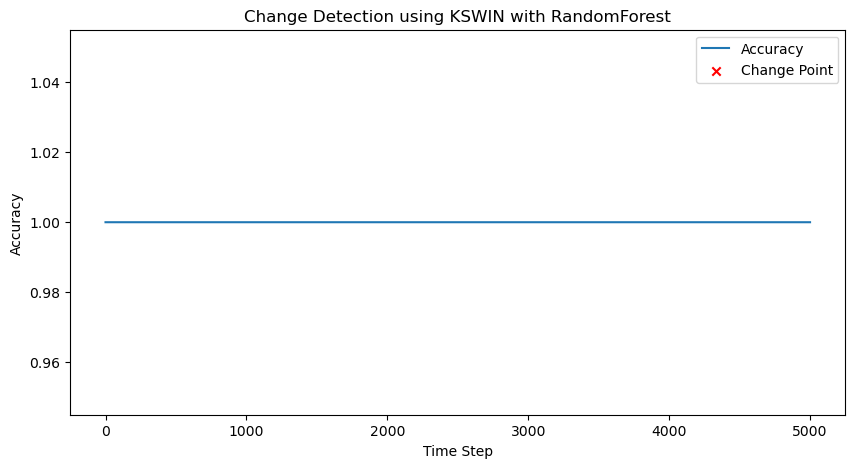

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(len(whole_df)), accuracies, label='Accuracy')
plt.scatter(change_points_kswin, [accuracies[i] for i in change_points_kswin], color='red', marker='x', label='Change Point')
plt.title('Change Detection using KSWIN with RandomForest')
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()